In [1]:
from pycaret.regression import load_model, predict_model

In [3]:
model = load_model('models/559_6_6_1_LGBMRegressor_41d80224-a2cd-4514-afd7-89f7808d6144')

Transformation Pipeline and Model Successfully Loaded


In [4]:
model

Pipeline(memory=FastMemory(location=C:\Users\spito\AppData\Roaming\MobaXterm\slash\var\log\xwin\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['bg_value__variance_larger_than_standard_deviation',
                                             'bg_value__has_duplicate_max',
                                             'bg_value__has_duplicate_min',
                                             'bg_value__has_duplicate',
                                             'bg_value__sum_values',
                                             'bg_value__abs_energy',
                                             'bg_va...
                ('onehot_encoding',
                 TransformerWrapper(include=['part_of_day'],
                                    transformer=OneHotEncoder(cols=['part_of_day'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('feature_selection',
                 TransformerWrapper(exclude=[],
                                    transformer=SelectFromModel(estimator=LGBMRegressor(),
                                                                max_features=56,
                                                                threshold=-inf))),
                ('trained_model', LGBMRegressor(random_state=1974))])

In [5]:
from src.bgc_providers.ohio_bgc_provider import OhioBgcProvider
test_provider = OhioBgcProvider()
test_dataframe = test_provider.tsfresh_dataframe()

In [7]:
mock_last_measurements = test_dataframe.head(6)
mock_last_measurements

,date_time,mock_date,time_of_day,part_of_day,time,bg_value,id
0,2021-12-07 01:17:00,2021-12-07,01:17:00,late night,0.00,101,a
1,2021-12-07 01:22:00,2021-12-07,01:22:00,late night,0.08,98,a
2,2021-12-07 01:27:00,2021-12-07,01:27:00,late night,0.17,104,a
3,2021-12-07 01:32:00,2021-12-07,01:32:00,late night,0.25,112,a
4,2021-12-07 01:37:00,2021-12-07,01:37:00,late night,0.33,120,a
5,2021-12-07 01:42:00,2021-12-07,01:42:00,late night,0.42,127,a


In [15]:
from src.featurizers.tsfresh import TsfreshFeaturizer
test_features = TsfreshFeaturizer(mock_last_measurements, 6, 6, plot_chunks=True, minimal_features=False)

In [24]:
test_features.chunks = 1
test_features.chunks

1

  0%|          | 0/1 [00:00<?, ?it/s]

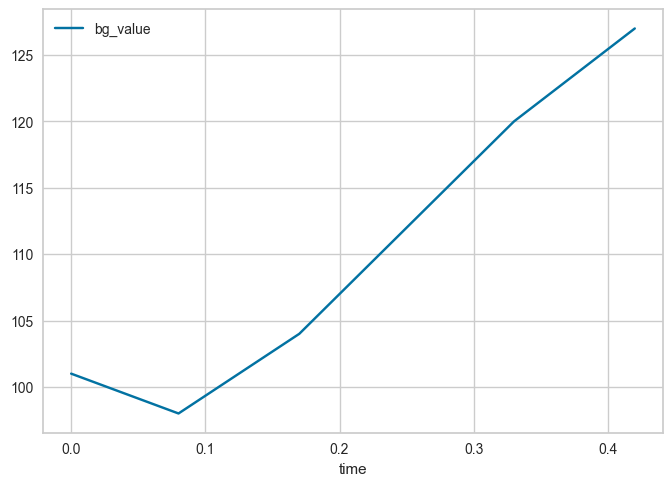

100%|██████████| 1/1 [00:07<00:00,  7.94s/it]


In [25]:
test_features.create_feature_dataframe()

In [27]:
features = test_features.feature_dataframe
features

,bg_value__variance_larger_than_standard_deviation,bg_value__has_duplicate_max,bg_value__has_duplicate_min,bg_value__has_duplicate,bg_value__sum_values,bg_value__abs_energy,bg_value__mean_abs_change,bg_value__mean_change,bg_value__mean_second_derivative_central,bg_value__median,...,bg_value__permutation_entropy__dimension_7__tau_1,bg_value__query_similarity_count__query_None__threshold_0.0,bg_value__mean_n_absolute_max__number_of_maxima_7,start,end,start_time,end_time,start_time_of_day,end_time_of_day,part_of_day
0,1.0,0.0,0.0,0.0,662.0,73694.0,6.4,5.2,1.25,108.0,...,NaN,NaN,NaN,0,5,0.0,0.42,01:17:00,01:42:00,late night


In [16]:
# features = test_features.calculate_master_features()
# features
# test_features.feature_dataframe

,bg_value__variance_larger_than_standard_deviation,bg_value__has_duplicate_max,bg_value__has_duplicate_min,bg_value__has_duplicate,bg_value__sum_values,bg_value__abs_energy,bg_value__mean_abs_change,bg_value__mean_change,bg_value__mean_second_derivative_central,bg_value__median,...,bg_value__permutation_entropy__dimension_4__tau_1,bg_value__permutation_entropy__dimension_5__tau_1,bg_value__permutation_entropy__dimension_6__tau_1,bg_value__permutation_entropy__dimension_7__tau_1,bg_value__query_similarity_count__query_None__threshold_0.0,bg_value__mean_n_absolute_max__number_of_maxima_7,start,end,start_time,end_time
a,1.0,0.0,0.0,0.0,662.0,73694.0,6.4,5.2,1.25,108.0,...,0.636514,0.693147,-0.0,NaN,NaN,NaN,all,all,,


In [28]:
features.index

RangeIndex(start=0, stop=1, step=1)

In [21]:
import pandas as pd
long = pd.melt(features)
long.set_index('variable', inplace=True)
long


,value
variable,
bg_value__variance_larger_than_standard_deviation,1.0
bg_value__has_duplicate_max,0.0
bg_value__has_duplicate_min,0.0
bg_value__has_duplicate,0.0
bg_value__sum_values,662.0
...,...
bg_value__mean_n_absolute_max__number_of_maxima_7,NaN
start,all
end,all


In [29]:
predict_model(model, features)

KeyError: "['bg_value__symmetry_looking__r_00', 'bg_value__symmetry_looking__r_005', 'bg_value__symmetry_looking__r_01', 'bg_value__symmetry_looking__r_015000000000000002', 'bg_value__symmetry_looking__r_02', 'bg_value__symmetry_looking__r_025', 'bg_value__symmetry_looking__r_030000000000000004', 'bg_value__symmetry_looking__r_035000000000000003', 'bg_value__symmetry_looking__r_04', 'bg_value__symmetry_looking__r_045', 'bg_value__symmetry_looking__r_05', 'bg_value__symmetry_looking__r_055', 'bg_value__symmetry_looking__r_06000000000000001', 'bg_value__symmetry_looking__r_065', 'bg_value__symmetry_looking__r_07000000000000001', 'bg_value__symmetry_looking__r_075', 'bg_value__symmetry_looking__r_08', 'bg_value__symmetry_looking__r_08500000000000001', 'bg_value__symmetry_looking__r_09', 'bg_value__symmetry_looking__r_09500000000000001', 'bg_value__large_standard_deviation__r_005', 'bg_value__large_standard_deviation__r_01', 'bg_value__large_standard_deviation__r_015000000000000002', 'bg_value__large_standard_deviation__r_02', 'bg_value__large_standard_deviation__r_025', 'bg_value__large_standard_deviation__r_030000000000000004', 'bg_value__large_standard_deviation__r_035000000000000003', 'bg_value__large_standard_deviation__r_04', 'bg_value__large_standard_deviation__r_045', 'bg_value__large_standard_deviation__r_05', 'bg_value__large_standard_deviation__r_055', 'bg_value__large_standard_deviation__r_06000000000000001', 'bg_value__large_standard_deviation__r_065', 'bg_value__large_standard_deviation__r_07000000000000001', 'bg_value__large_standard_deviation__r_075', 'bg_value__large_standard_deviation__r_08', 'bg_value__large_standard_deviation__r_08500000000000001', 'bg_value__large_standard_deviation__r_09', 'bg_value__large_standard_deviation__r_09500000000000001', 'bg_value__quantile__q_01', 'bg_value__quantile__q_02', 'bg_value__quantile__q_03', 'bg_value__quantile__q_04', 'bg_value__quantile__q_06', 'bg_value__quantile__q_07', 'bg_value__quantile__q_08', 'bg_value__quantile__q_09', 'bg_value__agg_autocorrelation__f_agg_mean__maxlag_40', 'bg_value__agg_autocorrelation__f_agg_median__maxlag_40', 'bg_value__agg_autocorrelation__f_agg_var__maxlag_40', 'bg_value__index_mass_quantile__q_01', 'bg_value__index_mass_quantile__q_02', 'bg_value__index_mass_quantile__q_03', 'bg_value__index_mass_quantile__q_04', 'bg_value__index_mass_quantile__q_06', 'bg_value__index_mass_quantile__q_07', 'bg_value__index_mass_quantile__q_08', 'bg_value__index_mass_quantile__q_09', 'bg_value__cwt_coefficients__coeff_0__w_2__widths_251020', 'bg_value__cwt_coefficients__coeff_0__w_5__widths_251020', 'bg_value__cwt_coefficients__coeff_0__w_10__widths_251020', 'bg_value__cwt_coefficients__coeff_0__w_20__widths_251020', 'bg_value__cwt_coefficients__coeff_1__w_2__widths_251020', 'bg_value__cwt_coefficients__coeff_1__w_5__widths_251020', 'bg_value__cwt_coefficients__coeff_1__w_10__widths_251020', 'bg_value__cwt_coefficients__coeff_1__w_20__widths_251020', 'bg_value__cwt_coefficients__coeff_2__w_2__widths_251020', 'bg_value__cwt_coefficients__coeff_2__w_5__widths_251020', 'bg_value__cwt_coefficients__coeff_2__w_10__widths_251020', 'bg_value__cwt_coefficients__coeff_2__w_20__widths_251020', 'bg_value__cwt_coefficients__coeff_3__w_2__widths_251020', 'bg_value__cwt_coefficients__coeff_3__w_5__widths_251020', 'bg_value__cwt_coefficients__coeff_3__w_10__widths_251020', 'bg_value__cwt_coefficients__coeff_3__w_20__widths_251020', 'bg_value__cwt_coefficients__coeff_4__w_2__widths_251020', 'bg_value__cwt_coefficients__coeff_4__w_5__widths_251020', 'bg_value__cwt_coefficients__coeff_4__w_10__widths_251020', 'bg_value__cwt_coefficients__coeff_4__w_20__widths_251020', 'bg_value__cwt_coefficients__coeff_5__w_2__widths_251020', 'bg_value__cwt_coefficients__coeff_5__w_5__widths_251020', 'bg_value__cwt_coefficients__coeff_5__w_10__widths_251020', 'bg_value__cwt_coefficients__coeff_5__w_20__widths_251020', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_02__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_02__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_02__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_02__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_04__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_04__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_04__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_04__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_06__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_06__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_06__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_06__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_08__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_08__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_08__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_08__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_10__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_10__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_10__ql_00', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_10__ql_00', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_04__ql_02', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_04__ql_02', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_04__ql_02', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_04__ql_02', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_06__ql_02', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_06__ql_02', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_06__ql_02', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_06__ql_02', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_08__ql_02', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_08__ql_02', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_08__ql_02', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_08__ql_02', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_10__ql_02', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_10__ql_02', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_10__ql_02', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_10__ql_02', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_06__ql_04', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_06__ql_04', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_06__ql_04', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_06__ql_04', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_08__ql_04', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_08__ql_04', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_08__ql_04', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_08__ql_04', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_10__ql_04', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_10__ql_04', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_10__ql_04', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_10__ql_04', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_08__ql_06', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_08__ql_06', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_08__ql_06', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_08__ql_06', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_10__ql_06', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_10__ql_06', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_10__ql_06', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_10__ql_06', 'bg_value__change_quantiles__f_agg_mean__isabs_False__qh_10__ql_08', 'bg_value__change_quantiles__f_agg_var__isabs_False__qh_10__ql_08', 'bg_value__change_quantiles__f_agg_mean__isabs_True__qh_10__ql_08', 'bg_value__change_quantiles__f_agg_var__isabs_True__qh_10__ql_08', 'bg_value__fft_coefficient__attr_real__coeff_0', 'bg_value__fft_coefficient__attr_real__coeff_1', 'bg_value__fft_coefficient__attr_real__coeff_2', 'bg_value__fft_coefficient__attr_real__coeff_3', 'bg_value__fft_coefficient__attr_imag__coeff_0', 'bg_value__fft_coefficient__attr_imag__coeff_1', 'bg_value__fft_coefficient__attr_imag__coeff_2', 'bg_value__fft_coefficient__attr_imag__coeff_3', 'bg_value__fft_coefficient__attr_abs__coeff_0', 'bg_value__fft_coefficient__attr_abs__coeff_1', 'bg_value__fft_coefficient__attr_abs__coeff_2', 'bg_value__fft_coefficient__attr_abs__coeff_3', 'bg_value__fft_coefficient__attr_angle__coeff_0', 'bg_value__fft_coefficient__attr_angle__coeff_1', 'bg_value__fft_coefficient__attr_angle__coeff_2', 'bg_value__fft_coefficient__attr_angle__coeff_3', 'bg_value__fft_aggregated__aggtype_centroid', 'bg_value__fft_aggregated__aggtype_variance', 'bg_value__value_count__value_1_217', 'bg_value__range_count__max_1__min_1', 'bg_value__range_count__max_0__min_10000000000000', 'bg_value__range_count__max_10000000000000__min_0', 'bg_value__approximate_entropy__m_2__r_01', 'bg_value__approximate_entropy__m_2__r_03', 'bg_value__approximate_entropy__m_2__r_05', 'bg_value__approximate_entropy__m_2__r_07', 'bg_value__approximate_entropy__m_2__r_09', 'bg_value__linear_trend__attr_pvalue', 'bg_value__linear_trend__attr_rvalue', 'bg_value__linear_trend__attr_intercept', 'bg_value__linear_trend__attr_slope', 'bg_value__linear_trend__attr_stderr', 'bg_value__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_max', 'bg_value__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_min', 'bg_value__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_mean', 'bg_value__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_var', 'bg_value__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_max', 'bg_value__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_min', 'bg_value__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_mean', 'bg_value__agg_linear_trend__attr_intercept__chunk_len_5__f_agg_var', 'bg_value__agg_linear_trend__attr_slope__chunk_len_5__f_agg_max', 'bg_value__agg_linear_trend__attr_slope__chunk_len_5__f_agg_min', 'bg_value__agg_linear_trend__attr_slope__chunk_len_5__f_agg_mean', 'bg_value__agg_linear_trend__attr_slope__chunk_len_5__f_agg_var', 'bg_value__agg_linear_trend__attr_stderr__chunk_len_5__f_agg_max', 'bg_value__agg_linear_trend__attr_stderr__chunk_len_5__f_agg_min', 'bg_value__agg_linear_trend__attr_stderr__chunk_len_5__f_agg_mean', 'bg_value__agg_linear_trend__attr_stderr__chunk_len_5__f_agg_var', 'bg_value__augmented_dickey_fuller__attr_usedlag__autolag_AIC', 'bg_value__number_crossing_m__m_1_250', 'bg_value__ratio_beyond_r_sigma__r_05', 'bg_value__ratio_beyond_r_sigma__r_15', 'bg_value__ratio_beyond_r_sigma__r_25'] not in index"